# Detector efficiency calculator for NIST DTSA-II simulations
Apply a custom detector X-ray transmission efficiency curve (DEC) to an EDS spectrum (e.g. from DTSA Monte-Carlo simulations). DTSA has the common Moxtek AP3.3 window implemented, whose influence can be simulated directly. However, other custom DECs are not yet implemented. So this notebook shows a workaround: Simulate in DTSA without a DEC (i.e. 100% X-ray transmission for all energies), then apply your custom DEC afterwards.  
As an example, an FEI/ThermoFisher Super-X windowless detector is used, but you can just use another .csv/.txt file with the transmission efficiencies for your EDS detector.  

### Example: Interpolation of SDD window efficiency of Super-X detector
Data for SuperX was taken from the publication of [Schlossmacher](https://analyticalscience.wiley.com/do/10.1002/micro.504/full/i2552fe95211c69c3cfa01cd212a664c3.pdf) (Fig. 4b). Data from the plot was read out using [webplotdigitizer](https://automeris.io/WebPlotDigitizer/). 

In [1]:
%matplotlib nbagg
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import numpy as np
import hyperspy.api as hs

Load data for Super-X SDD:

In [2]:
data = np.loadtxt('SuperX_SDD.txt', delimiter=';')

In [3]:
x = data[:,0]
y = data[:,1]

Use spline to interpolate data as continous curve. This needs some improvement to better fit the datapoints.  
(Fitting a physical equation that describes the DEC/$\epsilon$ might be better, e.g. as describe by eq. (1) in http://www.geoscience.wisc.edu/~johnf/g777/MM/Alvisi-EDSefficiency.pdf)

In [4]:
f = interp1d(x, y, fill_value=0)

Plot curves

<IPython.core.display.Javascript object>


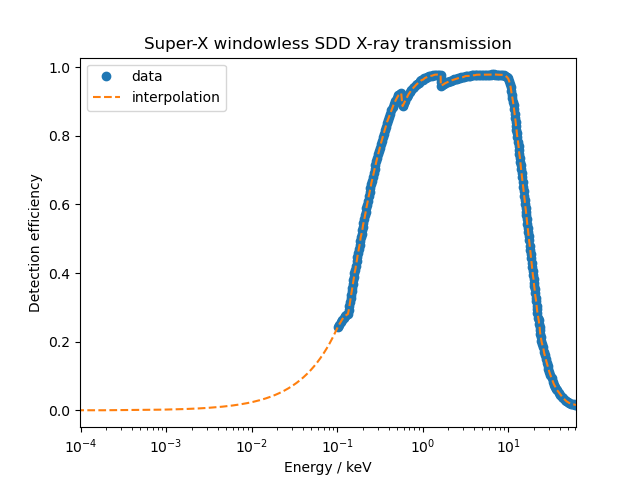

C:\Users\gruenewald\.conda\envs\lukasbase2\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  after removing the cwd from sys.path.


In [5]:
xnew = np.linspace(min(x), max(x), num=100000)        
plt.plot(x, y, 'o', xnew, f(xnew), '--')
plt.xscale('log')         
plt.xlim((0, max(x)))
plt.legend(['data', 'interpolation'], loc='best')
plt.xlabel('Energy / keV')
plt.ylabel('Detection efficiency')
plt.title('Super-X windowless SDD X-ray transmission')
plt.show()

### Discretize transmission function to match detector dispersion
Change the values to match the ones from the detector settings (number of channels and dispersion (keV/channel)).

Set desired amount of detector channels (N) and channel width/dispersion (in keV):

In [6]:
#These were settings for max energy of ~ 40 keV, 10 eV/channel
N = 4096
disp = 0.01

Generate energy channels:

In [7]:
channels = np.arange(N)*disp+disp/2

In [8]:
e = f(channels)

<IPython.core.display.Javascript object>


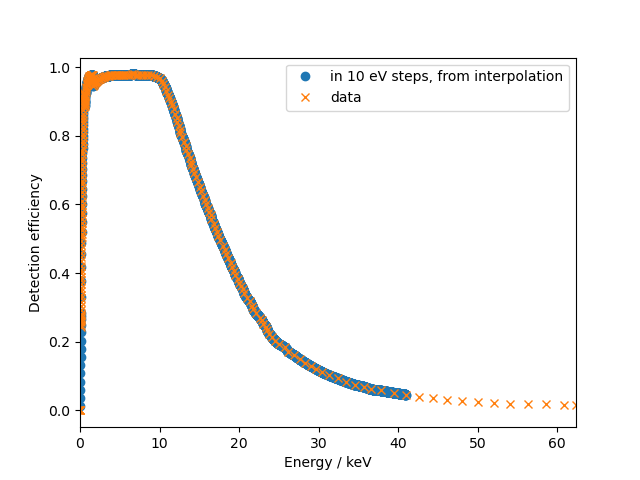

Text(0, 0.5, 'Detection efficiency')

In [12]:
plt.figure()
plt.plot(channels, e, 'o', x, y, 'x')
plt.xlim((0, max(x)))
plt.legend(['in 10 eV steps, from interpolation', 'data'], loc='best')
plt.xlabel('Energy / keV')
plt.ylabel('Detection efficiency')

Use HyperSpy to convert to signal and then to save as msa spectrum file:

In [13]:
DEC = hs.signals.Signal1D(e)

In [14]:
DEC.set_signal_type('EDS_TEM')
DEC.axes_manager[0].units = 'keV'
DEC.axes_manager[0].scale = disp

In [15]:
filename = 'SuperX_Ch'+str(N)+'_Disp'+str(int(disp))+'keV_2.msa'
DEC.save(filename)

You can easily inspect the saved transmission curve by dragging the msa file into the DTSA window.

## Apply detector efficiency curve (DEC) to a spectrum
The following part loads an (simulated) EDS spectrum, multiplies it with a DEC and saves it as a new spectrum. In contrast to the procedure above, an additional spectrum offset is read out from the EDS spectrum an applied to the DEC.  
As an example, a simulated spectrum from DTSA is used (5 nm of SrTiO$_3$ at 200 keV). Most important, no detector window/Si detector thickness was specified, i.e. 100% X-ray detection efficiency for all energies. The detector channels, dispersion and energy offset are now read out from the simulated spectrum.

Load a (simulated) spectrum:

In [16]:
s = hs.load('Sim_SrTiO3_200.0keV_5.0nm.msa')
s.set_signal_type('EDS_TEM')

In [17]:
s

<EDSTEMSpectrum, title: Noisy[MC simulation of a multilayer film [5 nm of SrTiO3] at 200.0 keV + CSF + BSF], dimensions: (|4096)>

Convert from eV to keV **if necessary**. The simulated spectrum msa is calibrated in eV:

In [18]:
s.axes_manager

Signal axis name,size,offset,scale,units
Energy (eV),4096,-951.43824,9.992,eV


In [19]:
s.axes_manager[0].offset /= 1000 
s.axes_manager[0].scale /= 1000 
s.axes_manager[0].units = 'keV' 

We have to match the spectrum energy axis offset:

In [20]:
DEC.axes_manager[0].offset #from DEC

0.0

In [21]:
s.axes_manager[0].offset #from simulated spectrum, DTSA saves it in eV

-0.95143824

Generate DEC:

In [22]:
channels = np.arange(np.shape(s)[0]) * s.axes_manager[0].scale + s.axes_manager[0].scale/2 + s.axes_manager[0].offset

In [23]:
e = f(channels)

In [24]:
DEC = hs.signals.Signal1D(e)
DEC.set_signal_type('EDS_TEM')
DEC.axes_manager[0].units = 'keV'
DEC.axes_manager[0].scale = s.axes_manager[0].scale
DEC.axes_manager[0].offset = s.axes_manager[0].offset

<IPython.core.display.Javascript object>


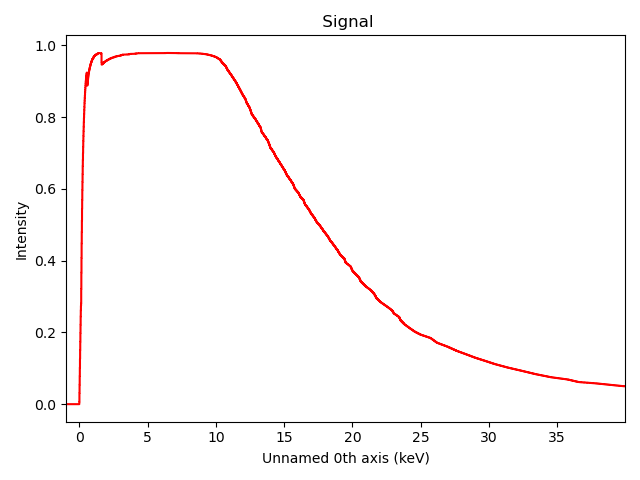

<IPython.core.display.Javascript object>


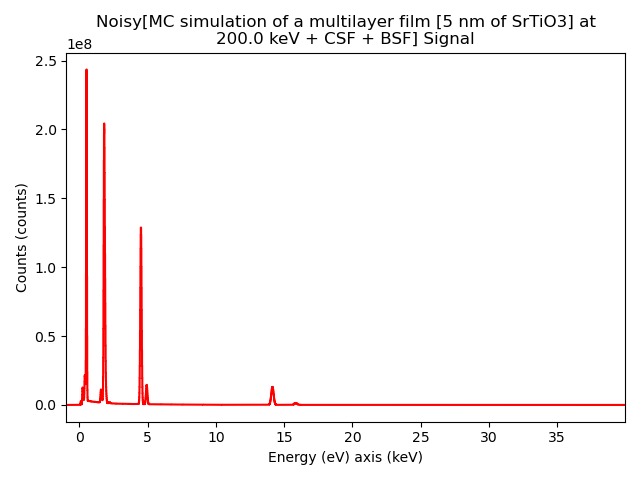

In [25]:
DEC.plot()
s.plot()

Optional: Save generated DEC as msa spectrum:

In [26]:
filename = 'SuperX_Ch'+str(N)+'_Disp'+str(np.around(s.axes_manager[0].scale,3))+'keV_Offset'+str(np.around(s.axes_manager[0].offset,3))+'keV.msa'
DEC.save(filename)

Now multiply DEC with spectrum, i.e. model window transmission efficiency of the detector:

In [27]:
s2 = DEC*s

Visualize results (here, spectra are normalized to maximum of s):

<IPython.core.display.Javascript object>


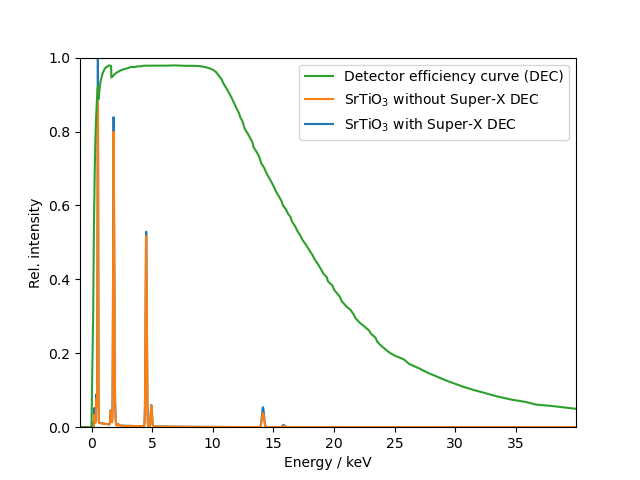

Text(0, 0.5, 'Rel. intensity')

In [31]:
hs.plot.plot_spectra([s/s.data.max(), s2/s.data.max(), DEC], legend=['SrTiO$_3$ with Super-X DEC', 'SrTiO$_3$ without Super-X DEC', 'Detector efficiency curve (DEC)'])
plt.xlabel('Energy / keV')
plt.ylabel('Rel. intensity')

In [29]:
s2.save('Sim_STO_5nm_withDEC.msa')